#CIS5190 Final Project ---- Stock Price Prediction
By Xinyu Cai, Wanqing Ding and Leila Zhu<br>
April 22nd, 2023

In [227]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

# For time stamps
from datetime import datetime

# Model import
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#ARIMA Model
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

#**I. Stock Price Data**
[Link to CSV](https://www.kaggle.com/code/ysthehurricane/advanced-stock-pred-using-svr-rfr-knn-lstm-gru/input)

## 1.1 Data Loading and Basic Preprocessing

In [228]:
#unhashtag to install PyDrive install once
#!pip install -U -q PyDrive

#import dataset from GoogleDrive set up
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#please authenticate.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#files should be accessible using berkeley.edu
stock_link = 'https://drive.google.com/file/d/1bKGOTVhOuAAv7D1iD0F2lOkm7YrRMOJU/view?usp=share_link'
downloaded = drive.CreateFile({'id':"1bKGOTVhOuAAv7D1iD0F2lOkm7YrRMOJU"}) 
downloaded.GetContentFile('RELIANCE.csv')  
df = pd.read_csv('RELIANCE.csv')

The dataset consists of historical stock prices for a particular company. The data covers a period from 08/19/2020 to 08/18/2021 and includes information on the opening, closing, high, and low prices for the stock, as well as the volume of shares traded on each day. Additionally, the dataset includes information on the adjusted close price, which takes into account any dividends or stock splits that may have occurred during the time period. 

In [229]:
# sneak peak at the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-19,2141.000000,2154.000000,2121.350098,2131.550049,2124.715088,15731396.0
1,2020-08-20,2120.000000,2123.899902,2088.000000,2097.050049,2090.325684,10401212.0
2,2020-08-21,2118.000000,2122.000000,2077.000000,2081.850098,2075.174316,11667129.0
3,2020-08-24,2091.399902,2104.500000,2070.500000,2095.750000,2089.029785,15098991.0
4,2020-08-25,2106.000000,2111.300049,2078.000000,2082.100098,2075.423584,8947563.0


In [230]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,249.000000,249.000000,249.000000,249.000000,249.000000,2.490000e+02
mean,2068.014859,2089.614047,2040.812858,2062.776310,2057.475665,1.169959e+07
std,110.235282,111.434759,108.422569,109.656764,110.108616,7.600158e+06
min,1837.000000,1905.000000,1830.000000,1841.949951,1836.043579,3.099956e+06
25%,1980.000000,1997.199951,1960.000000,1976.099976,1969.763428,6.821015e+06
50%,2071.000000,2089.800049,2035.099976,2055.699951,2053.250000,9.591456e+06
75%,2136.449951,2153.550049,2104.250000,2134.250000,2130.446533,1.414742e+07
max,2325.000000,2369.350098,2310.550049,2324.550049,2317.096191,6.475046e+07


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       249 non-null    float64
 2   High       249 non-null    float64
 3   Low        249 non-null    float64
 4   Close      249 non-null    float64
 5   Adj Close  249 non-null    float64
 6   Volume     249 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.8+ KB


In [232]:
df.Date.min()

'2020-08-19'

In [233]:
df.Date.max()

'2021-08-18'

## 1.2 Data Preprocessing

Checking Null Values

In [234]:
# Checking null value
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Looking at the info table and checking null values above, we can see that all columns have 1 row of `NaN` values except the Date column. In fact, there are only 1 row of missing value in the entire dataframe! We are going to drop this one row, so that information we kept is still complete and essential. We procede by dropping the missing value rows.

In [235]:
df.dropna(inplace=True)
df.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

Convert Date from String to Date format in order for the modeling part.

In [236]:
# convert date field from string to Date format and make it index
df['Date'] = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-19,2141.000000,2154.000000,2121.350098,2131.550049,2124.715088,15731396.0
1,2020-08-20,2120.000000,2123.899902,2088.000000,2097.050049,2090.325684,10401212.0
2,2020-08-21,2118.000000,2122.000000,2077.000000,2081.850098,2075.174316,11667129.0
3,2020-08-24,2091.399902,2104.500000,2070.500000,2095.750000,2089.029785,15098991.0
4,2020-08-25,2106.000000,2111.300049,2078.000000,2082.100098,2075.423584,8947563.0


#**II. EDA**

### 2.1 Data Visualization

#### Close Price

The closing price of a stock is the final price at which the stock is traded during a specific trading day. It represents the market's consensus value of a stock at the end of the trading session. Investors and financial analysts often use the closing price as a reference point for assessing the stock's performance over time, comparing it to previous closing prices to analyze trends and make investment decisions.

#### Open Price

Open price for a stock refers to the initial price at which a share of a particular company begins trading when the stock market opens for the day. The open price is influenced by various factors, including pre-market trading, the previous day's closing price, overall market sentiment, news and events related to the company or the broader market, and the supply and demand for the stock.

#### High Price

The high price for a stock refers to the highest price at which a share of a particular company has traded during a specific period, such as a trading day, week, month, or year. The high price represents the peak value that investors were willing to pay for the stock during that time frame. 

#### Low Price

The low price for a stock refers to the lowest price at which a share of a particular company has traded during a specific period, such as a trading day, week, month, or year. The low price represents the minimum value that investors were willing to pay for the stock during that time frame. This information is often used by traders and investors to analyze price trends, as well as to assess the stock's historical performance and potential support levels in technical analysis. Similar to the high price, the low price is not static and will change as new low prices are reached.

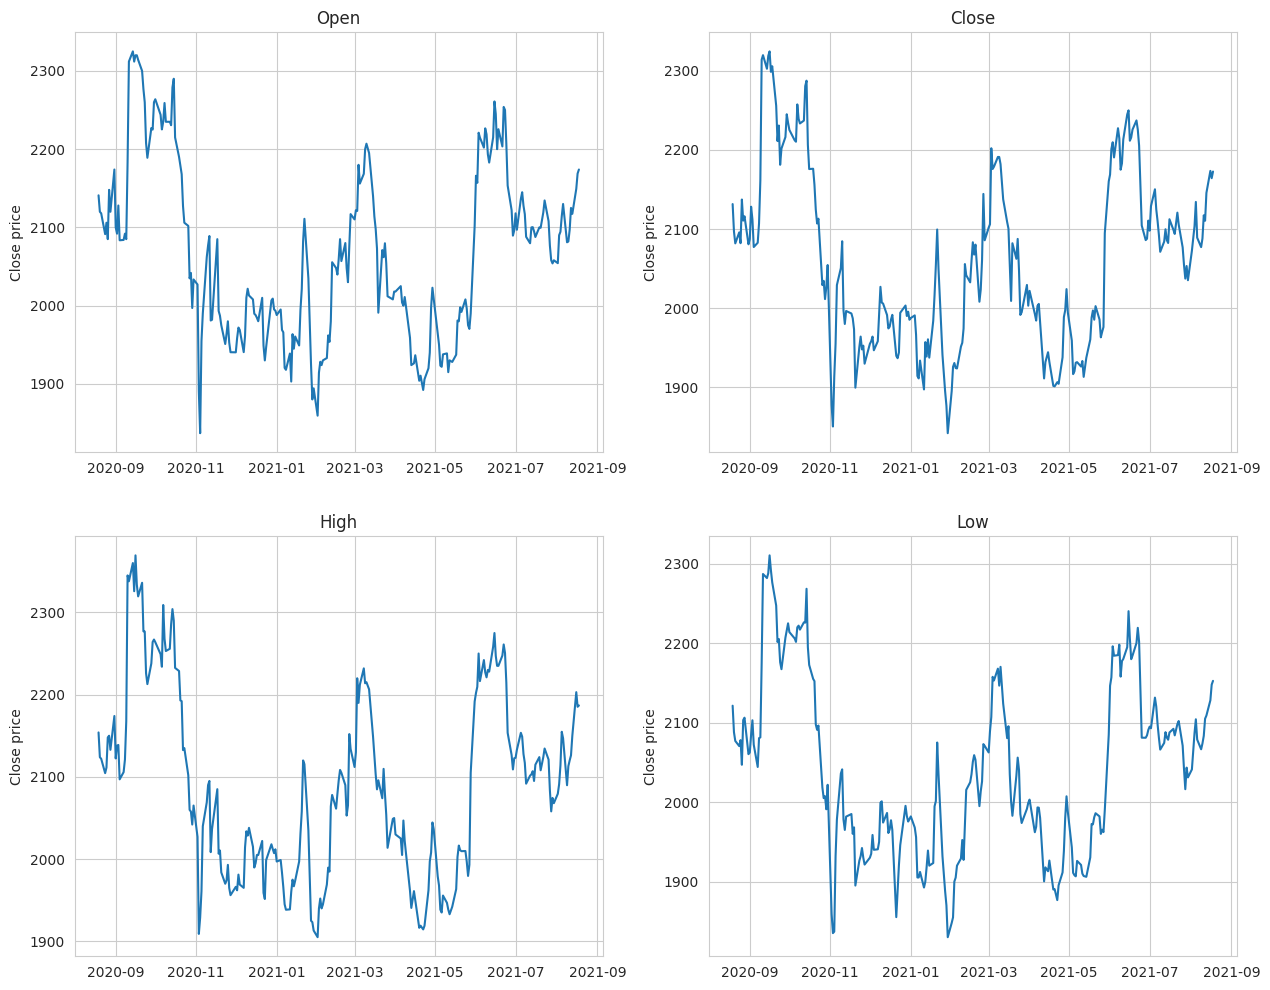

In [237]:
plt.figure(figsize=(15, 12))
column = ['Open', 'Close', 'High', 'Low']
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.plot(df.Date, df[column[i]])
  plt.ylabel('Close price')
  plt.grid(True)
  plt.title(str(column[i]))

### 2.2 Moving Average

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

In [238]:
ma_day = [10, 20, 50]

for ma in ma_day:
      column_name = f"MA for {ma} days"
      df[column_name] = df['Close'].rolling(ma).mean()

Text(0.5, 1.0, 'Moving Average for Close Price')

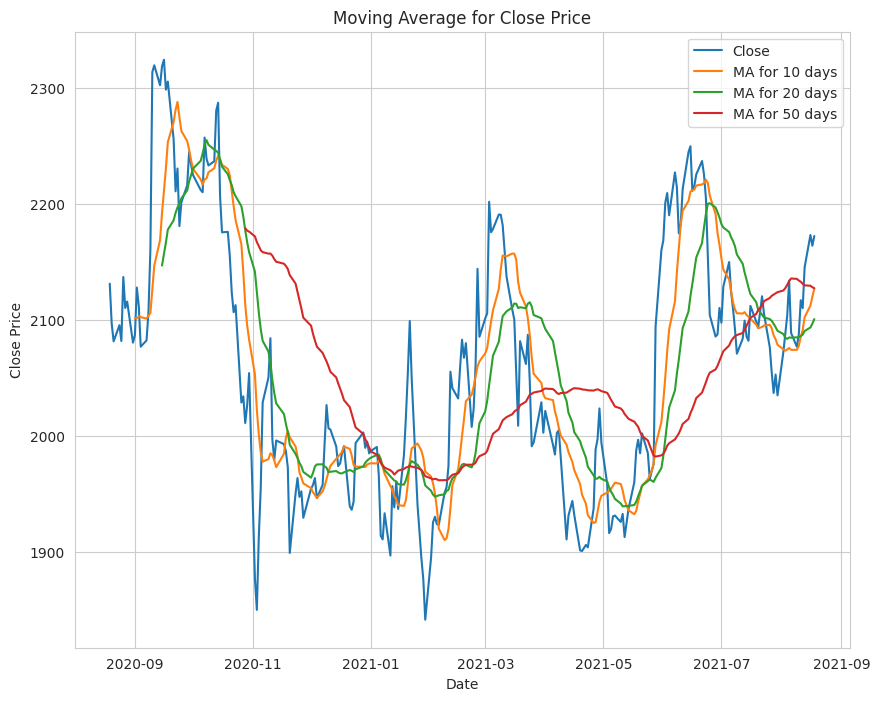

In [239]:
plt.figure(figsize=(10, 8))
plt.plot(df.Date, df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']])
plt.legend(['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.grid(True)
plt.title('Moving Average for Close Price')

### 2.3 Daily Return

We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the stock.

Text(0.5, 1.0, 'Daily Return (% Change)')

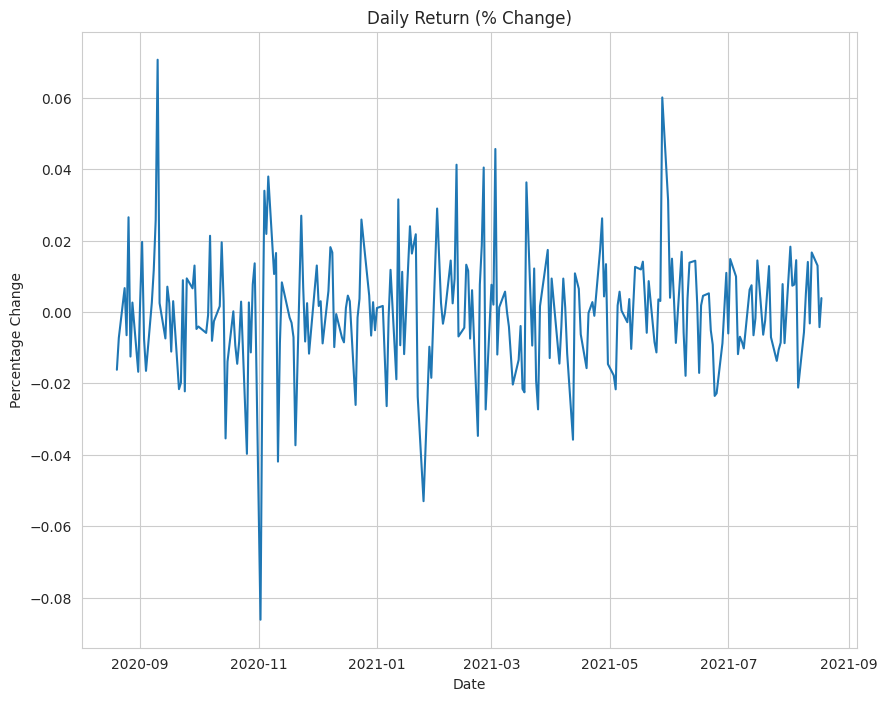

In [240]:
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(10, 8))
plt.plot(df.Date, df['Daily Return'])
plt.ylabel('Percentage Change')
plt.xlabel('Date')
plt.grid(True)
plt.title('Daily Return (% Change)')

#**III. Modeling**

## 3.0 Data Preparation Before Model

In [241]:
df_model = df[["Open", "High", "Low", "Volume", "Close"]]

In [242]:
training_size=int(len(df_model)*0.07)
train_df = df_model.loc[0:training_size,]
test_df = df_model.loc[training_size:, ]
X_train = train_df[["Open", "High", "Low", "Volume"]]
y_train = train_df["Close"]
X_test = test_df[["Open", "High", "Low", "Volume"]]
y_test = test_df["Close"]

## 3.1 OLS

### 3.1.1 Model

In [244]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [245]:
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

### 3.1.2 Evaluation

**Evaluation metrices RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

1. **MSE (Mean Squared Error)**: MSE is the average of the squared differences between the actual and predicted values.

2. **RMSE (Root Mean Squared Error)**: RMSE is the square root of the MSE.

3. **MAE (Mean Absolute Error)**: MAE is the average of the absolute differences between the actual and predicted values.

In [246]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,y_train_pred_lr)))
print("Train data MSE: ", mean_squared_error(y_train,y_train_pred_lr))
print("Train data MAE: ", mean_absolute_error(y_train,y_train_pred_lr))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,y_test_pred_lr)))
print("Test data MSE: ", mean_squared_error(y_test,y_test_pred_lr))
print("Test data MAE: ", mean_absolute_error(y_test,y_test_pred_lr))

Train data RMSE:  7.7583254264666035
Train data MSE:  60.1916134229582
Train data MAE:  5.6806059870100905
-------------------------------------------------------------------------------------
Test data RMSE:  14.237806183931678
Test data MSE:  202.71512493120312
Test data MAE:  10.897197372121438


The difference between the train and test data metrics is not significant, which is a good sign. This indicates that the model is not overfitting, as the performance on the test set is similar to that on the training set.

**Explained Variance Score**


Explained variance regression score is an evaluation metric used in regression tasks to measure the proportion of the total variance in the target variable that is explained by the predictive model. It is a useful metric for understanding how well the model captures the underlying structure of the data. It ranges from 0 to 1, with 1 being the best possible score. A score of 1 indicates that the model perfectly explains the variance in the target variable, while a score of 0 indicates that the model does not explain any variance in the target variable.

In [247]:
print("Train data explained variance regression score:", explained_variance_score(y_train, y_train_pred_lr))
print("Test data explained variance regression score:", explained_variance_score(y_test, y_test_pred_lr))

Train data explained variance regression score: 0.9877511908925743
Test data explained variance regression score: 0.985410641498906


The explained variance regression score is quite high for both the train and test data, which indicates that the model maybe is doing a good job of capturing the variance in the target variable (stock price).

**R<sup>2</sup> score**

The R-squared (R2) score, also known as the coefficient of determination, is a metric used to evaluate the performance of a regression model. It measures the proportion of the variance in the dependent variable (target) that can be explained by the independent variables (predictors) in the model.

The R2 score ranges from 0 to 1, with higher values indicating a better fit of the model to the data. An R2 score of 1 indicates that the model explains 100% of the variance in the target variable, while an R2 score of 0 means that the model does not explain any variance in the target variable.

In [248]:
print("Train data R2 score:", r2_score(y_train, y_train_pred_lr))
print("Test data R2 score:", r2_score(y_test, y_test_pred_lr))

Train data R2 score: 0.9877511908925743
Test data R2 score: 0.9836524428987388


The R-squared score, which measures the proportion of the total variance in the target variable explained by the model, is also high for both the train and test data. This means that the model is accounting for a large portion of the variability in the stock prices.

**Prediction Visualization**

We draw a plot to compare between the original stock close price and predicted close price for test dataset.

In [249]:
df_plot_lr = df[["Date"]]
df_plot_lr = df_plot_lr.loc[training_size:, ]
df_plot_lr["y_test"] = y_test
df_plot_lr["y_test_pred_lr"] = y_test_pred_lr

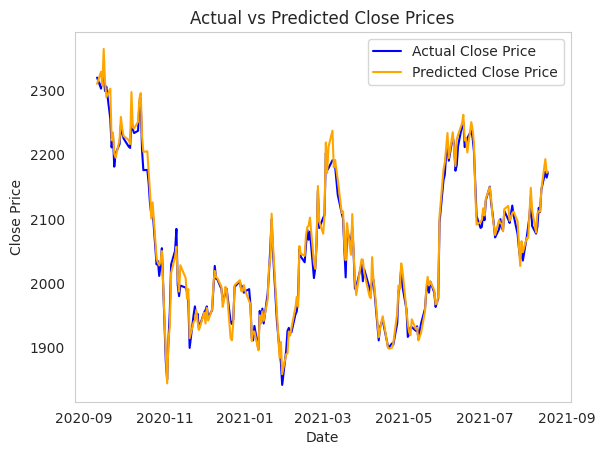

In [250]:
# Plot the actual and predicted close prices
plt.plot(df_plot_lr['Date'], df_plot_lr['y_test'], label='Actual Close Price', color='blue')
plt.plot(df_plot_lr['Date'], df_plot_lr['y_test_pred_lr'], label='Predicted Close Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

### 3.1.3 Summarization

We see that linear regression gives a very good result overall. **However**, the Linear Regression actually gives a very bad prediction for stock price. Here are some of the key reasons why linear regression might not be a good model for predicting stock prices:

1. **Linearity assumption**: Linear regression assumes that the relationship between the independent and dependent variables is linear. However, stock prices are influenced by a multitude of factors, including market sentiment, economic indicators, and company-specific news, which can cause nonlinear relationships between the predictors and stock prices.

2. **Independence of observations**: Linear regression assumes that the observations are independent of each other. In the case of stock prices, this is not true, as prices are influenced by past prices and market trends, resulting in a time series data structure with inherent autocorrelation.

3. **Constant variance (homoscedasticity)**: Linear regression assumes that the variance of the error terms is constant across all levels of the independent variables. Stock prices are known to exhibit heteroscedasticity, with periods of high volatility followed by periods of low volatility.

4. **Normal distribution of errors**: Linear regression assumes that the error terms follow a normal distribution. However, stock prices tend to exhibit non-normal distributions, with heavy tails (kurtosis) and skewness, which violates this assumption.

## 3.2 Support Vector Regression (SVR)

Support Vector Regression (SVR) is the combination of a Support Vector Machines and Regression.

What is **Support Vector Machine**?

* Support Vector Machines (SVMs) are used for classification. The goal of an SVM is to define a boundary line between the 2 classes on a graph. We can think of this as “splitting” the data in the best possible way. This boundary line is called a hyperplane.
* The hyperplane in an SVM has a “margin” or distance between the 2 classes. These 2 lines that make up the margin are the distance from the hyperplane to the closest data example in each class. These lines are called boundary lines.
* When determining boundary lines with a SVM, we want the margin to be the widest possible distance between the 2 classes. This will help the SVM generalize when it sees new data that it needs to classify.

What is **Support Vector Regressor**?
* Linear Regression won’t work on our data because our data has many fluctuations and a linear line of best fit would give poor predictions on stock data. A SVM will not work on our data because we aren’t classifying between two different classes.
* With stock data, we are not predicting a class, we are predicting the next value in a series.
* Using regression we try to minimize the cost function using something like gradient descent. With SVMs we try to try to draw a hyperplane between 2 different classes. So SVR is the combo of the 2, we try to minimize the error within a certain threshold.

### 3.2.1 Data Preparation for SVR

We are going to predict the stock price using Support Vector Regression. In order to let the model learn more efficiently, we will treat this as a time series question. In other words, our sole x feature will be the close price. Thus, we will redo the data preparation in this section.

**Normalize Close Price**

Normalizing the close price of a stock before implementing a model to predict stock prices is important for several reasons:

1. Scale uniformity: Financial data can have a wide range of values, which can lead to inconsistencies in scale when comparing different stocks or other financial instruments. Normalization helps to ensure that all data points are on a similar scale, allowing the model to process and compare them more effectively.

2. Improved convergence: Machine learning models, particularly neural networks, often perform better and converge faster when their input features have similar scales. Normalizing the data helps to prevent any single feature from dominating the learning process, which could lead to suboptimal results or slow convergence.

3. Comparability: When working with time series, normalizing the close prices enables easier comparison between them. This is particularly useful when you want to analyze or predict trends across different stocks or market sectors.

4. Mitigating the impact of outliers: Extreme values or outliers in the data can disproportionately affect the model's predictions. By normalizing the close prices, the influence of outliers is reduced, leading to more robust and accurate predictions.

In [251]:
# Select the close price column (replace 'close' with the actual column name in your dataset)
close_price = df['Close']

# Reshape the close price data
close_price = np.array(close_price).reshape(-1, 1)

# Initialize the MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the close price data
normalized_close_price = scaler.fit_transform(close_price)

**Split into train and test data set**

We can't use train_test_split to split the data in the time series model. Instead, we can only split the data sequentially. We use 80% of the data for training, and 20% of the data for testing.

In [252]:
training_size=int(len(close_price)*0.80)
train_df = normalized_close_price[0:training_size,]
test_df = normalized_close_price[training_size:, ]
print("train_df: ", train_df.shape)
print("test_df: ", test_df.shape)

train_df:  (199, 1)
test_df:  (50, 1)


**Transform Close price base on Time-series-analysis forecasting requirement**

Now, we are going to create x and label features for the model. We will create in this way:

**Example**

Suppose we have a following sequence of time series data:

Sequence: 367, 363, 364, 368, 371, 372, 369, 367, 366

Timestamp = 3

\begin{array}{|c|c|} \hline
Train Data & Label\\ \hline
367, 363, 364 & 368 \\ \hline
363, 364, 368 & 371 \\\hline
364, 368, 371 & 372 \\ \hline
368, 371, 372 & 369  \\ \hline
371, 372, 369 & 367  \\ \hline
372, 369, 367 & 366 \\ \hline
\end{array}

In [253]:
def create_dataset(dataset, time_step=1):
    dataX = [dataset[i:(i + time_step), 0] for i in range(len(dataset) - time_step - 1)]
    dataY = [dataset[i + time_step, 0] for i in range(len(dataset) - time_step - 1)]
    
    return np.array(dataX), np.array(dataY)

In [254]:
time_step = 10
X_train_ts, y_train_ts = create_dataset(train_df, time_step)
X_test_ts, y_test_ts = create_dataset(test_df, time_step)

print("X_train_ts: ", X_train_ts.shape)
print("y_train_ts: ", y_train_ts.shape)
print("X_test_ts: ", X_test_ts.shape)
print("y_test_ts", y_test_ts.shape)

X_train_ts:  (188, 10)
y_train_ts:  (188,)
X_test_ts:  (39, 10)
y_test_ts (39,)


### 3.2.2 Base Line Model

In [343]:
svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_train_ts, y_train_ts)

SVR(C=100.0, gamma=0.1)

In [344]:
y_train_pred_svr_rbf=svr_rbf.predict(X_train_ts)
y_test_pred_svr_rbf=svr_rbf.predict(X_test_ts)

In [345]:
# Transform back to original form
y_train_pred_svr_rbf = scaler.inverse_transform(y_train_pred_svr_rbf.reshape(-1,1))
y_test_pred_svr_rbf = scaler.inverse_transform(y_test_pred_svr_rbf.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

#### 3.2.2.1 Evaluation (Base Line Model)

**Evaluation metrices RMSE, MSE and MAE**

In [346]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,y_train_pred_svr_rbf)))
print("Train data MSE: ", mean_squared_error(original_y_train,y_train_pred_svr_rbf))
print("Train data MAE: ", mean_absolute_error(original_y_train,y_train_pred_svr_rbf))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,y_test_pred_svr_rbf)))
print("Test data MSE: ", mean_squared_error(original_y_test,y_test_pred_svr_rbf))
print("Test data MAE: ", mean_absolute_error(original_y_test,y_test_pred_svr_rbf))

Train data RMSE:  36.61734093223515
Train data MSE:  1340.829656947544
Train data MAE:  27.694221864252782
-------------------------------------------------------------------------------------
Test data RMSE:  30.287911251655746
Test data MSE:  917.3575679881748
Test data MAE:  25.555430577507725


**Explained Variance Score**

In [347]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, y_train_pred_svr_rbf))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, y_test_pred_svr_rbf))

Train data explained variance regression score: 0.8988966261389487
Test data explained variance regression score: 0.2793721714200442


**R<sup>2</sup> score**

In [261]:
print("Train data R2 score:", r2_score(original_y_train, y_train_pred_svr_rbf))
print("Test data R2 score:", r2_score(original_y_test, y_test_pred_svr_rbf))

Train data R2 score: 0.8988518118689208
Test data R2 score: 0.2570711144517227


**Prediction Visualization**

The code below was based on the original code of this [Kaggle notenook](https://www.kaggle.com/code/ysthehurricane/advanced-stock-pred-using-svr-rfr-knn-lstm-gru/notebook). However, the code below was improved based on the original one and was organized using function.

In [348]:
def prepare_predictions_plot(closedf, train_predict, test_predict, time_step):
    look_back = time_step
    trainPredictPlot = np.empty_like(closedf)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

    testPredictPlot = np.empty_like(closedf)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(closedf) - 1, :] = test_predict

    return trainPredictPlot, testPredictPlot

def plot_stock_prices(close_stock, closedf, trainPredictPlot, testPredictPlot):
    names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

    plotdf = pd.DataFrame({'date': close_stock['Date'],
                           'original_close': close_stock['Close'],
                           'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(),
                           'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()})

    fig = px.line(plotdf, x='date', y=['original_close', 'train_predicted_close', 'test_predicted_close'],
                  labels={'value': 'Stock price', 'date': 'Date'})
    fig.update_layout(title_text='Comparison between Close Price vs Predicted Close Price',
                      plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
    fig.for_each_trace(lambda t: t.update(name=next(names)))

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

close_stock = df[["Date", "Close"]]
trainPredictPlot, testPredictPlot = prepare_predictions_plot(close_price, y_train_pred_svr_rbf, y_test_pred_svr_rbf, 10)
plot_stock_prices(close_stock, close_price, trainPredictPlot, testPredictPlot)

Based on the evaluation metric of the SVR base line model, we can see that:

1. **Error Metrics**:

The RMSE, MSE, and MAE values for the train data are 36.62, 1340.83, and 27.69, respectively. For the test data, the values are 30.29, 917.36, and 25.56. These error metrics provide a quantitative measure of the prediction errors for both training and test datasets. Lower values of these metrics indicate better model performance. The model has lower error values for the test data compared to the train data, which is a positive sign.

2. **Explained Variance Regression Score**:

The explained variance regression score for the train data is 0.8989, while for the test data, it is 0.2794. A higher score indicates a better fit of the model. The significantly lower explained variance score for the test data suggests that the model might not generalize well to unseen data.
3. **R2 Score**:

The R2 score, also known as the coefficient of determination, for the train data is 0.8989, and for the test data, it is 0.2571. An R2 score of 1 indicates a perfect fit, while an R2 score of 0 indicates no fit. The R2 score for the test data is quite lower than the train data, which again indicates that the model might not be generalizing well to new data.

In summary, the model appears to perform well on the training data but does not generalize as well to the test data, as indicated by the lower explained variance regression score and R2 score for the test data. This could be a sign of overfitting, meaning the model has learned the noise in the training data instead of the underlying pattern. To improve the model's performance on unseen data, we decide to tune the hyperparameters of the SVR model using Grid Search Cross Validation.

### 3.2.3 Hyperparameter Tuning: SVR with Grid Search

SVR has several hyperparameters that control its behavior and performance. We will tune 3 parameters in the following section:

1. **Kernel**: The kernel function used to transform the input data into a higher-dimensional space. Common choices for the kernel function include 'linear', 'poly', 'rbf' (Radial basis function), and 'sigmoid'. We will fix the kernel to be 'rbf'.

2. **C (Cost or Regularization parameter)**: This parameter controls the trade-off between achieving a low training error and a low testing error, i.e., the balance between overfitting and underfitting. A smaller value of C creates a wider margin, which may result in more training errors but better generalization to the test data. A larger value of C creates a narrower margin, which minimizes training errors at the potential cost of poorer generalization.

3. **epsilon**: This parameter defines the 'insensitive zone' within which no penalty is associated with errors. It controls the width of the tube around the regression line, inside which errors are not penalized. A larger epsilon value results in a smoother regression function, while a smaller epsilon value results in a more flexible function that may be more prone to overfitting.

4. **gamma**: It controls the shape of the decision boundary. A small gamma value will produce a more flexible decision boundary, while a large gamma value will produce a more rigid boundary. 

In [349]:
paramters = {
        'C':[0.001,0.01,0.1,1,100],
        'epsilon': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.01, 0.1, 1, 5, 8, 40]
    }

In [350]:
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=paramters,
        cv=10,
        scoring='neg_mean_squared_error'
    )

In [351]:
grid_result = gsc.fit(X_train_ts,y_train_ts)

In [352]:
best_param = grid_result.best_params_
svr_model = SVR(kernel='rbf', C=best_param['C'], epsilon=best_param['epsilon'], gamma=best_param['gamma'])
svr_model.fit(X_train_ts, y_train_ts)
y_train_pred_svr_rbf_cv=svr_model.predict(X_train_ts)
y_test_pred_svr_rbf_cv=svr_model.predict(X_test_ts)

In [353]:
# Transform back to original form
y_train_pred_svr_rbf_cv = scaler.inverse_transform(y_train_pred_svr_rbf_cv.reshape(-1,1))
y_test_pred_svr_rbf_cv = scaler.inverse_transform(y_test_pred_svr_rbf_cv.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

#### 3.2.3.1 Evaluation (Tuned Model)

In [354]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,y_train_pred_svr_rbf_cv)))
print("Train data MSE: ", mean_squared_error(original_y_train,y_train_pred_svr_rbf_cv))
print("Train data MAE: ", mean_absolute_error(original_y_train,y_train_pred_svr_rbf_cv))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,y_test_pred_svr_rbf_cv)))
print("Test data MSE: ", mean_squared_error(original_y_test,y_test_pred_svr_rbf_cv))
print("Test data MAE: ", mean_absolute_error(original_y_test,y_test_pred_svr_rbf_cv))

Train data RMSE:  36.95745267519318
Train data MSE:  1365.8533082391434
Train data MAE:  25.880811543151342
-------------------------------------------------------------------------------------
Test data RMSE:  23.452097267616303
Test data MSE:  550.0008662497361
Test data MAE:  19.744894560456185


In [355]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, y_train_pred_svr_rbf_cv))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, y_test_pred_svr_rbf_cv))

Train data explained variance regression score: 0.8969677441951807
Test data explained variance regression score: 0.5581110908554241


In [356]:
print("Train data R2 score:", r2_score(original_y_train, y_train_pred_svr_rbf_cv))
print("Test data R2 score:", r2_score(original_y_test, y_test_pred_svr_rbf_cv))

Train data R2 score: 0.8969641022889199
Test data R2 score: 0.554577686092877


In [357]:
trainPredictPlot, testPredictPlot = prepare_predictions_plot(close_price, y_train_pred_svr_rbf_cv, y_test_pred_svr_rbf_cv, 10)
plot_stock_prices(close_stock, close_price, trainPredictPlot, testPredictPlot)

### 3.2.5 SVR with Bagging

In [273]:
bagging_svr = BaggingRegressor(base_estimator = SVR(kernel='rbf', C=best_param['C'], epsilon=best_param['epsilon'], gamma=best_param['gamma']),n_estimators = 1000, random_state=42)
model = bagging_svr.fit(X_train_ts, y_train_ts)
y_train_pred_bag_svr = model.predict(X_train_ts)
y_test_pred_bag_svr = model.predict(X_test_ts)

In [274]:
# Transform back to original form
y_train_pred_bag_svr = scaler.inverse_transform(y_train_pred_bag_svr.reshape(-1,1))
y_test_pred_bag_svr = scaler.inverse_transform(y_test_pred_bag_svr.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1))

#### 3.2.5.1 Evaluation (Bagging SVR)

In [275]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,y_train_pred_bag_svr)))
print("Train data MSE: ", mean_squared_error(original_y_train,y_train_pred_bag_svr))
print("Train data MAE: ", mean_absolute_error(original_y_train,y_train_pred_bag_svr))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,y_test_pred_bag_svr)))
print("Test data MSE: ", mean_squared_error(original_y_test,y_test_pred_bag_svr))
print("Test data MAE: ", mean_absolute_error(original_y_test,y_test_pred_bag_svr))

Train data RMSE:  36.904684481288854
Train data MSE:  1361.9557366634824
Train data MAE:  26.06770762915965
-------------------------------------------------------------------------------------
Test data RMSE:  23.955168703769196
Test data MSE:  573.8501076260432
Test data MAE:  20.091621844913806


In [276]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, y_train_pred_bag_svr))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, y_test_pred_bag_svr))

Train data explained variance regression score: 0.8972581375417303
Test data explained variance regression score: 0.5405210663552481


In [277]:
print("Train data R2 score:", r2_score(original_y_train, y_train_pred_bag_svr))
print("Test data R2 score:", r2_score(original_y_test, y_test_pred_bag_svr))

Train data R2 score: 0.8972581234577884
Test data R2 score: 0.5352631996427037


In [278]:
trainPredictPlot, testPredictPlot = prepare_predictions_plot(close_price, y_train_pred_bag_svr, y_test_pred_bag_svr, 10)
plot_stock_prices(close_stock, close_price, trainPredictPlot, testPredictPlot)

### 3.2.6 Summarization

Here is a comparison of the two models, the tuned SVR model and the Bagging with tuned SVR model:

1. Error Metrics:

* Standalone SVR:
 * Train data: RMSE = 36.96, MSE = 1365.85, MAE = 25.88
 * Test data: RMSE = 23.45, MSE = 550.00, MAE = 19.74
* Bagging with SVR:
 * Train data: RMSE = 36.89, MSE = 1360.62, MAE = 26.05
 * Test data: RMSE = 23.88, MSE = 570.13, MAE = 20.04

The error metrics for both models are quite similar. The standalone SVR model has slightly lower error values for the test data compared to the Bagging with SVR model.

2. Explained Variance Regression Score:

* Standalone SVR:
 * Train data: 0.8970
 * Test data: 0.5581
* Bagging with SVR:
 * Train data: 0.8974
 * Test data: 0.5431

The explained variance regression scores for both models are also quite similar. The standalone SVR model has a slightly higher explained variance regression score for the test data compared to the Bagging with SVR model.

3. R2 Score:

* Standalone SVR:
 * Train data: 0.8970
 * Test data: 0.5546
* Bagging with SVR:
 * Train data: 0.8974
 * Test data: 0.5383

The R2 scores for the standalone SVR model and the Bagging with SVR model are also close. The standalone SVR model has a slightly higher R2 score for the test data compared to the Bagging with SVR model.

4. In summary, the standalone SVR model has marginally better performance on the test data compared to the Bagging with SVR model based on the error metrics, explained variance regression scores, and R2 scores. The differences between the two models are quite small, and it seems that bagging does not significantly improve the performance of SVR. SVR is generally considered a low-bias and low-variance algorithm, which means that it may not benefit as much from bagging as other algorithms with high variance (like decision trees).

## 3.3 Decision Tree Regressor

A Decision Tree Regressor can model complex relationships between input features and the target variable (in this case, stock prices) by recursively partitioning the data into subsets based on the values of the input features.

However, Decision Trees have some limitations when applied to time series data like stock prices. Decision Trees are not inherently designed to capture temporal dependencies present in time series data. To account for time dependencies, we will perform feature engineering that capture the historical information, such as lagged values or moving averages of the stock prices before building the model.



### 3.3.1 Feature Engineering

In this section, we will perform feature engineering to create additional features that capture relevant information from the time series data.

1. **Lagged values**: Create lagged features by shifting the close prices by different time steps (e.g., 1 day, 3 days). This captures the historical price information, which can help the model learn how past prices influence future prices.

2. **Moving averages**: Calculate simple moving averages (SMA) or exponential moving averages (EMA) of the close prices over different time windows (e.g., 5 days, 10 days, 30 days). Moving averages help smoothen the time series and capture trends in the data.

3. **Price change**: Compute the percentage change in close prices over different periods (e.g., daily, weekly, monthly). This feature can help the model capture the momentum and volatility of the stock price.

4. **Date-based features**: Extract features from the date, such as day of the week, day of the month, month, and quarter. These features can help the model capture any seasonality or cyclic patterns present in the stock price.

In [279]:
df_dt = df[["Close", "Open", "High", "Low", "Volume"]]

In [280]:
# Create lagged values
df_dt['lag_3'] = df_dt['Close'].shift(3)

# Calculate moving averages
df_dt['SMA_3'] = df_dt['Close'].rolling(window=3).mean()

# Calculate price change
df_dt['price_change'] = df_dt['Close'].diff()

# Add date-based features
df_dt['day_of_week'] = df['Date'].dt.dayofweek
df_dt['day_of_month'] = df['Date'].dt.day
df_dt['month'] = df['Date'].dt.month
df_dt['quarter'] = df['Date'].dt.quarter

# Remove rows with missing values caused by the shift and rolling operations
df_dt = df_dt.dropna()

Let's check the correlation between x variables.

In [281]:
df_dt.corr()

,Close,Open,High,Low,Volume,lag_3,SMA_3,price_change,day_of_week,day_of_month,month,quarter
Close,1.000000,0.953455,0.981978,0.983083,-0.021704,0.826471,0.968380,0.166914,0.003660,-0.028129,0.199370,0.135547
Open,0.953455,1.000000,0.979933,0.974627,-0.033906,0.879319,0.986534,-0.112986,-0.021612,0.002881,0.220859,0.162497
High,0.981978,0.979933,1.000000,0.974558,0.052481,0.858979,0.981977,0.031100,-0.008994,-0.002209,0.205271,0.141950
Low,0.983083,0.974627,0.974558,1.000000,-0.109218,0.854659,0.980079,0.044927,0.008856,-0.016712,0.207395,0.150388
Volume,-0.021704,-0.033906,0.052481,-0.109218,1.000000,-0.035841,-0.038057,0.074920,0.033848,0.032817,0.167996,0.147777
lag_3,0.826471,0.879319,0.858979,0.854659,-0.035841,1.000000,0.908473,-0.175075,-0.034950,0.063133,0.216976,0.169301
SMA_3,0.968380,0.986534,0.981977,0.980079,-0.038057,0.908473,1.000000,-0.060302,-0.009237,-0.007085,0.211095,0.150964
price_change,0.166914,-0.112986,0.031100,0.044927,0.074920,-0.175075,-0.060302,1.000000,0.037576,-0.082029,-0.018689,-0.035741
day_of_week,0.003660,-0.021612,-0.008994,0.008856,0.033848,-0.034950,-0.009237,0.037576,1.000000,0.032052,-0.011548,0.000084
day_of_month,-0.028129,0.002881,-0.002209,-0.016712,0.032817,0.063133,-0.007085,-0.082029,0.032052,1.000000,0.018547,0.027294


However, we see that there are high correlations between features Open, High, and Low, so we decide to drop these 3 features.

In [282]:
df_dt = df_dt.drop(["High", "Low", "Open"], axis =1)

### 3.3.2 Base Line Decision Tree Model

In [283]:
X = df_dt.loc[:, df_dt.columns != "Close"]
y = df_dt['Close']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [284]:
# Train the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [285]:
# Make predictions
y_train_pred_dt = dt_regressor.predict(X_train)
y_test_pred_dt = dt_regressor.predict(X_test)

#### 3.3.2.1 Evaluation (Base Line DT Model)

In [286]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,y_train_pred_dt)))
print("Train data MSE: ", mean_squared_error(y_train,y_train_pred_dt))
print("Train data MAE: ", mean_absolute_error(y_train,y_train_pred_dt))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,y_test_pred_dt)))
print("Test data MSE: ", mean_squared_error(y_test,y_test_pred_dt))
print("Test data MAE: ", mean_absolute_error(y_test,y_test_pred_dt))

Train data RMSE:  0.0
Train data MSE:  0.0
Train data MAE:  0.0
-------------------------------------------------------------------------------------
Test data RMSE:  25.530729134017115
Test data MSE:  651.8181301145503
Test data MAE:  20.703007879999987


In [287]:
print("Train data explained variance regression score:", explained_variance_score(y_train, y_train_pred_dt))
print("Test data explained variance regression score:", explained_variance_score(y_test, y_test_pred_dt))

Train data explained variance regression score: 1.0
Test data explained variance regression score: 0.9526589483353344


In [288]:
print("Train data R2 score:", r2_score(y_train, y_train_pred_dt))
print("Test data R2 score:", r2_score(y_test, y_test_pred_dt))

Train data R2 score: 1.0
Test data R2 score: 0.9526554013822485


The results of the Decision Tree Regressor model show a clear sign of overfitting. The training error metrics (RMSE, MSE, and MAE) are all 0, and the R2 score and explained variance regression score for the training data are both 1.0, which means the model has perfectly fit the training data. However, this perfection is not reflected in the test data results.

The test data error metrics (RMSE, MSE, and MAE) are significantly higher than those for the training data. Although the R2 score and explained variance regression score for the test data are relatively high (0.9526), the significant difference in performance between the training and test sets indicates that the model is overfitting to the training data and not generalizing well to new, unseen data.

To mitigate overfitting, we will consider the following approaches:

1. **Prune the decision tree**: Limit the depth of the tree, set a minimum number of samples required to split a node, or set a minimum number of samples required at a leaf node. These constraints can help make the tree less complex and more generalizable.

2. **Use cross-validation**: K-fold cross-validation can help you assess the model's performance more accurately and detect overfitting.

3. **Ensemble methods**: Combine multiple decision trees using methods like Random Forest or Gradient Boosting to reduce the likelihood of overfitting and improve the model's performance.

### 3.3.3 Decision Tree with Pruning

Pre-pruning is nothing but stopping the growth of the decision tree at an early stage. For that, we can limit the growth of trees by setting constraints. We can limit parameters like `max_depth`, `min_samples_split`, etc.

An effective way to do this is that we can grid search those parameters and choose the optimum values that give better performance on test data.

As of now, we will control these parameters

`max_depth`: maximum depth of decision tree

`min_sample_split`: The minimum number of samples required to split an internal node:

`min_samples_leaf`: The minimum number of samples required to be at a leaf node.

In [290]:
params = {'max_depth': [4,8,12],
         'min_samples_split': [4,6,8,10],
         'min_samples_leaf': [3,5,7,9,11]}

clf = DecisionTreeRegressor(random_state=42)
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [4, 8, 12],
                         'min_samples_leaf': [3, 5, 7, 9, 11],
                         'min_samples_split': [4, 6, 8, 10]})

In [291]:
gcv.best_estimator_

DecisionTreeRegressor(max_depth=12, min_samples_leaf=3, min_samples_split=4,
                      random_state=42)

Depth: 9
Leaves: 56


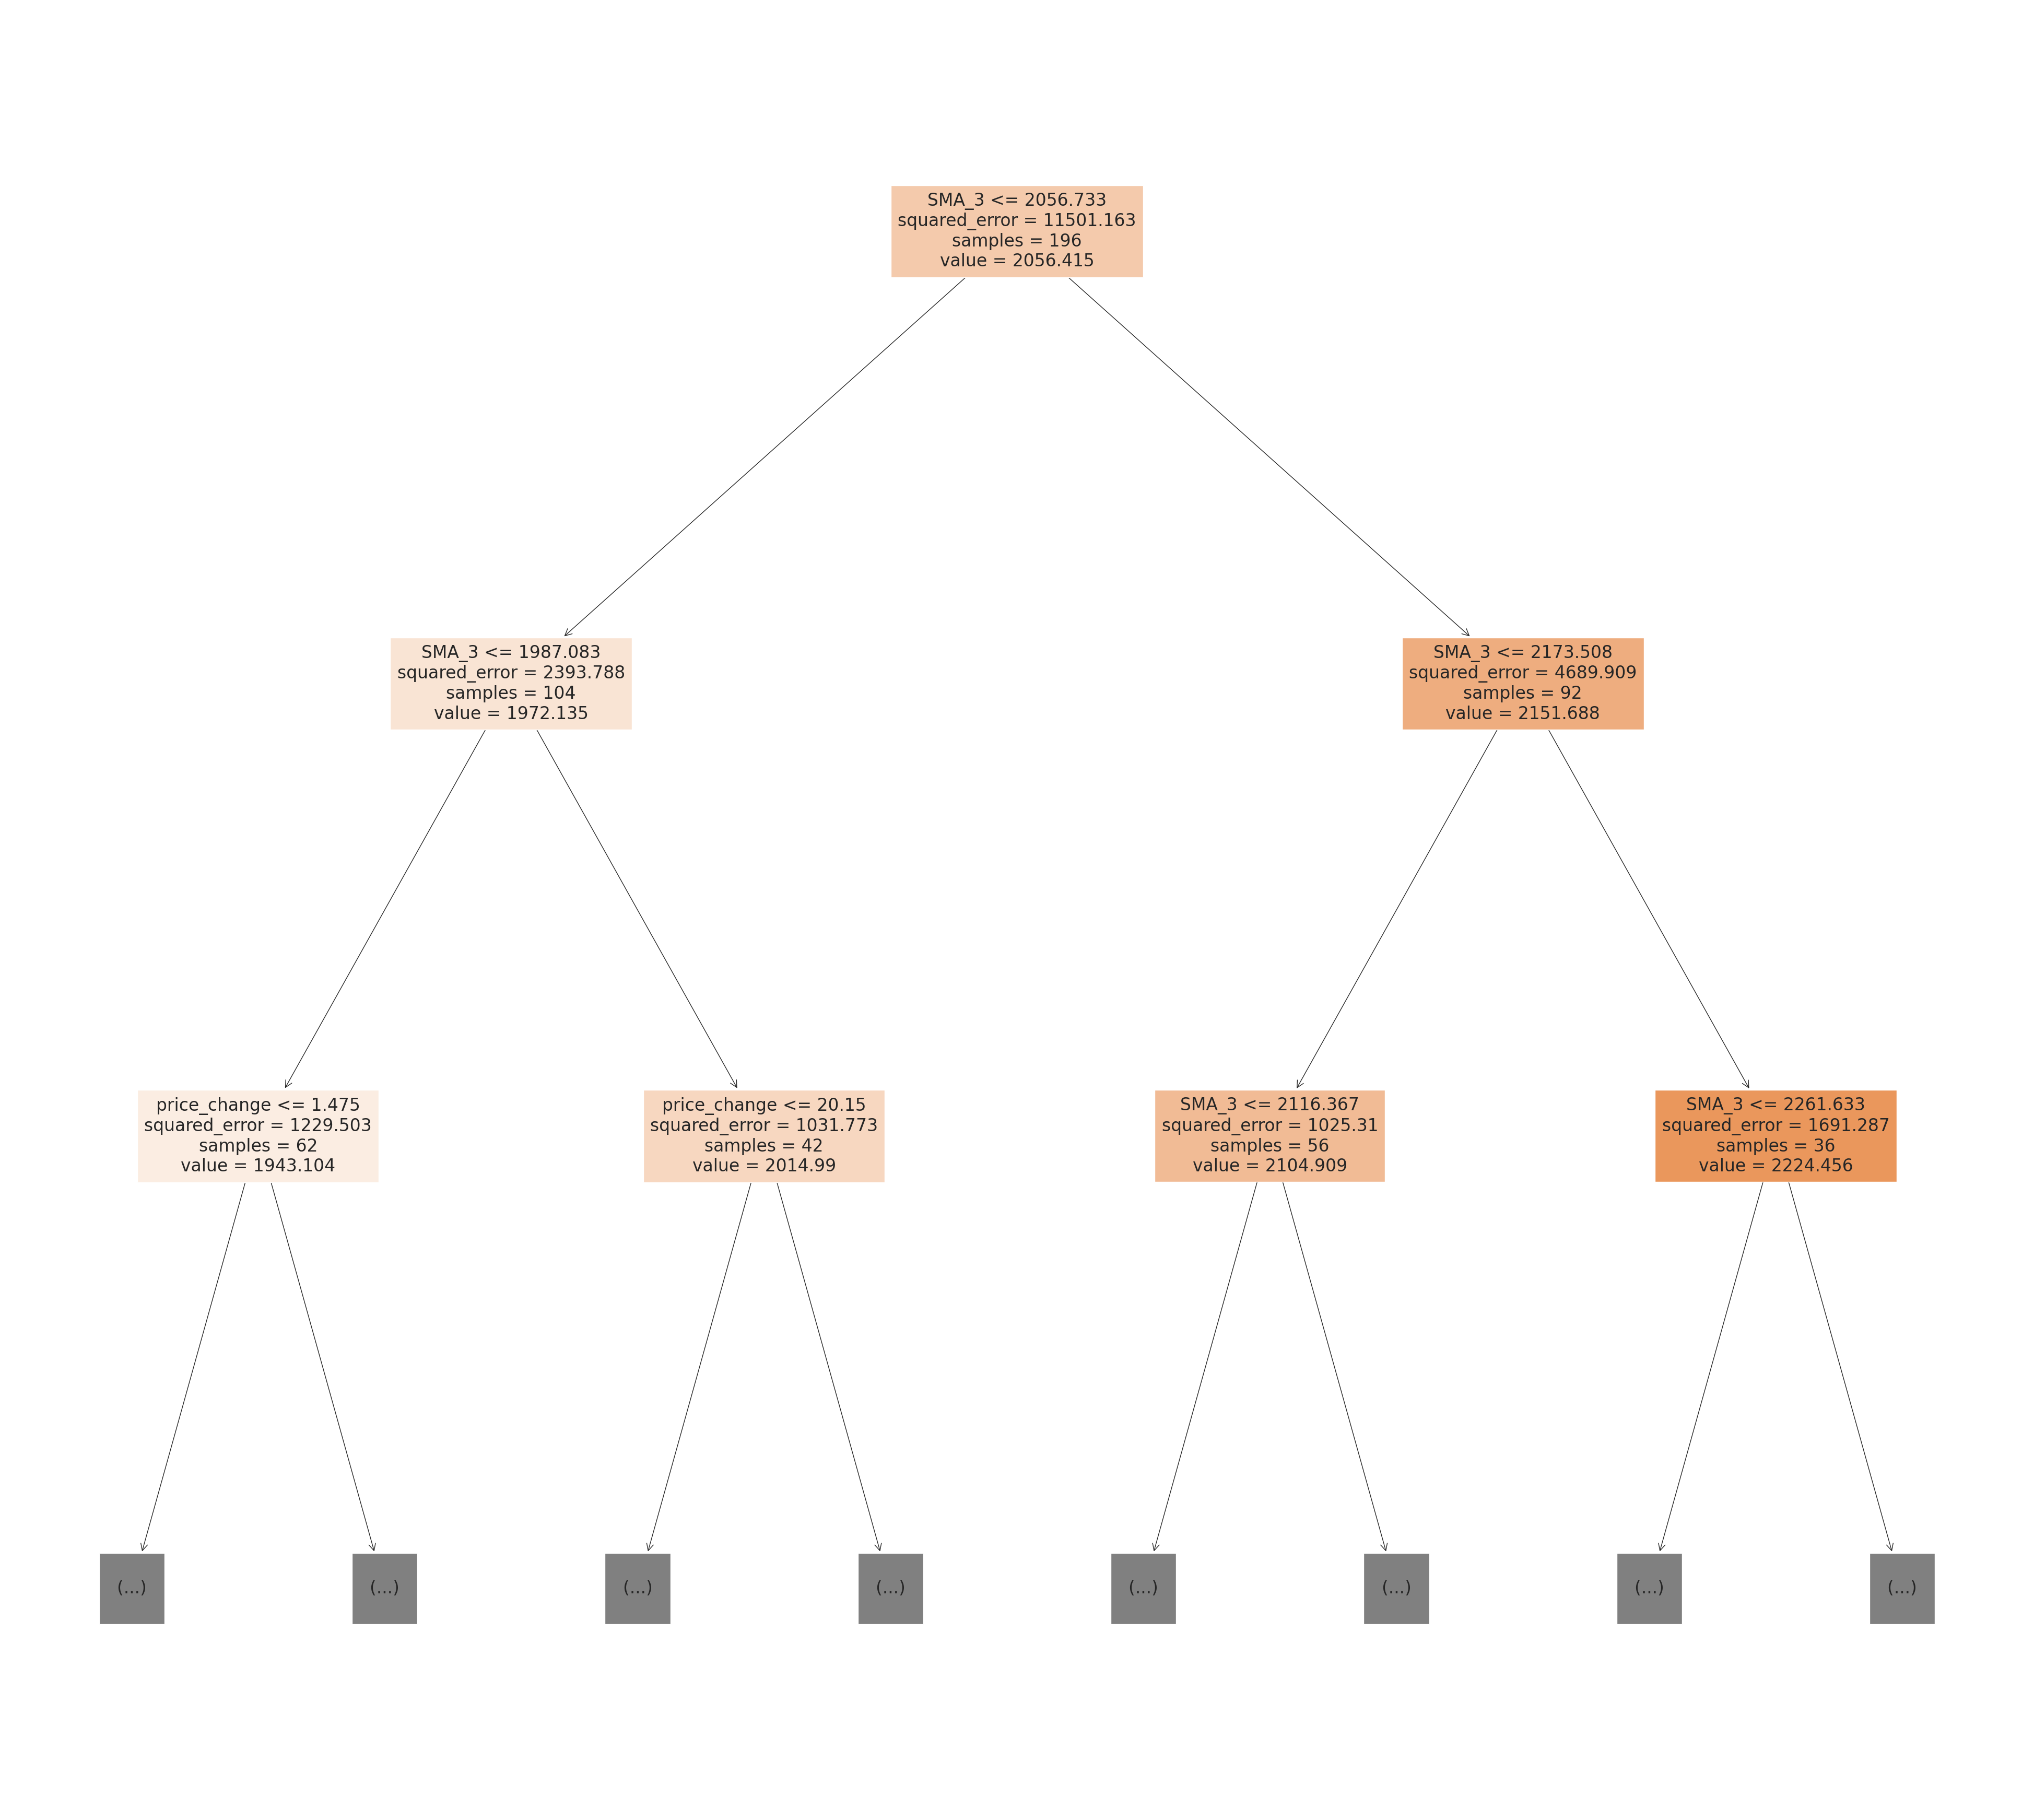

In [292]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred_dt_prune = model.predict(X_train)
y_test_pred_dt_prune = model.predict(X_test)
print("Depth: "+ str(model.tree_.max_depth)) #number of split levels
print("Leaves: "+ str(model.tree_.n_leaves))
fig = plt.figure(figsize=(50,45))
tree.plot_tree(model, feature_names = X_train.columns, filled=True, max_depth=2)
plt.show()

#### 3.3.3.1 Evaluation (Pruned DT Model)

In [293]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,y_train_pred_dt_prune)))
print("Train data MSE: ", mean_squared_error(y_train,y_train_pred_dt_prune))
print("Train data MAE: ", mean_absolute_error(y_train,y_train_pred_dt_prune))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,y_test_pred_dt_prune)))
print("Test data MSE: ", mean_squared_error(y_test,y_test_pred_dt_prune))
print("Test data MAE: ", mean_absolute_error(y_test,y_test_pred_dt_prune))

Train data RMSE:  10.119669215728795
Train data MSE:  102.40770503576904
Train data MAE:  7.351452255612249
-------------------------------------------------------------------------------------
Test data RMSE:  22.337670256008202
Test data MSE:  498.9715124661536
Test data MAE:  17.016643546999973


In [294]:
print("Train data explained variance regression score:", explained_variance_score(y_train, y_train_pred_dt_prune))
print("Test data explained variance regression score:", explained_variance_score(y_test, y_test_pred_dt_prune))

Train data explained variance regression score: 0.9910958827101278
Test data explained variance regression score: 0.9644247893105053


In [295]:
print("Train data R2 score:", r2_score(y_train, y_train_pred_dt_prune))
print("Test data R2 score:", r2_score(y_test, y_test_pred_dt_prune))

Train data R2 score: 0.9910958827101278
Test data R2 score: 0.9637573659154727


### 3.3.4 Comparison & Summarization

Comparing the two models, we can see that pruning the decision tree has led to a better model that generalizes well to unseen data. The first model without pruning is overfitting, as it has a perfect fit on the training data but performs worse on the test data. On the other hand, the second model with pruning has a more balanced performance, with lower error metrics (RMSE, MSE, and MAE) on the test data compared to the first model, and an increased R2 score and explained variance regression score on the test data. This indicates that the pruned decision tree generalizes better to new, unseen data. In conclusion, the pruned decision tree model is a better choice as it has a more balanced performance on both the training and test datasets, making it a more reliable model for predicting stock prices.

## 3.4 Random Forest Regressor

### 3.4.1 Base Line RFR

In [296]:
rf = RandomForestRegressor(n_estimators = 500, max_depth = 50, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=500, random_state=42)

In [297]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

#### 3.4.1.1 Evaluation (Base RFR)

In [298]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,y_train_pred_rf)))
print("Train data MSE: ", mean_squared_error(y_train,y_train_pred_rf))
print("Train data MAE: ", mean_absolute_error(y_train,y_train_pred_rf))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,y_test_pred_rf)))
print("Test data MSE: ", mean_squared_error(y_test,y_test_pred_rf))
print("Test data MAE: ", mean_absolute_error(y_test,y_test_pred_rf))

Train data RMSE:  8.141280758515625
Train data MSE:  66.28045238897677
Train data MAE:  5.593703603715306
-------------------------------------------------------------------------------------
Test data RMSE:  18.991261548142734
Test data MSE:  360.66801518996476
Test data MAE:  14.17957929260106


In [299]:
print("Train data explained variance regression score:", explained_variance_score(y_train, y_train_pred_rf))
print("Test data explained variance regression score:", explained_variance_score(y_test, y_test_pred_rf))

Train data explained variance regression score: 0.9942414413127665
Test data explained variance regression score: 0.9741849187124165


In [300]:
print("Train data R2 score:", r2_score(y_train, y_train_pred_rf))
print("Test data R2 score:", r2_score(y_test, y_test_pred_rf))

Train data R2 score: 0.9942370652492301
Test data R2 score: 0.9738029956140847


Let's analyze the results of the Random Forest Regressor and compare it to the pruned Decision Tree Regressor:

**Random Forest Regressor**:

* Train data RMSE: 7.9421446062381955, MSE: 63.07766094639847, MAE: 5.522461844623228
* Test data RMSE: 19.140588392718524, MSE: 366.362124019471, MAE: 14.179584527520719
* Train data R2 score and explained variance regression score: 0.9945155406886489 and 0.9945206308665216, respectively
* Test data R2 score and explained variance regression score: 0.9733894058647916 and 0.9737921087758319, respectively

**Pruned Decision Tree Regressor**:

* Train data RMSE: 10.168030656815592, MSE: 103.38884743794173, MAE: 7.471945828741504
* Test data RMSE: 21.427916079886256, MSE: 459.155587526648, MAE: 16.389308532833375
* Train data R2 score and explained variance regression score: 0.9910105746073444
* Test data R2 score and explained variance regression score: 0.966649382718571 and 0.9668627587874079, respectively

Comparing the two models, the Random Forest Regressor has better performance on the test dataset, with lower error metrics (RMSE, MSE, and MAE) and higher R2 score and explained variance regression score. This indicates that the Random Forest model generalizes better to new, unseen data than the pruned Decision Tree Regressor.

The Random Forest Regressor also performs well on the training dataset, but it does not overfit as much as the unpruned Decision Tree Regressor. It has a good balance between training and test dataset performance.

In conclusion, the Random Forest Regressor is a better model for predicting stock prices compared to the pruned Decision Tree Regressor, as it has a more balanced performance and better generalization to unseen data.

### 3.4.2 RFR Based on Time Series Data

In [301]:
rf_ts = RandomForestRegressor(n_estimators = 500, max_depth = 50, random_state = 42)
rf_ts.fit(X_train_ts, y_train_ts)

RandomForestRegressor(max_depth=50, n_estimators=500, random_state=42)

In [302]:
y_train_pred_rf_ts = rf_ts.predict(X_train_ts)
y_test_pred_rf_ts = rf_ts.predict(X_test_ts)

In [303]:
# Transform back to original form
y_train_pred_rf_ts = scaler.inverse_transform(y_train_pred_rf_ts.reshape(-1,1))
y_test_pred_rf_ts = scaler.inverse_transform(y_test_pred_rf_ts.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

#### 3.4.2.1 Evaluation (Time Series RFR Model)

In [304]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,y_train_pred_rf_ts)))
print("Train data MSE: ", mean_squared_error(original_y_train,y_train_pred_rf_ts))
print("Train data MAE: ", mean_absolute_error(original_y_train,y_train_pred_rf_ts))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,y_test_pred_rf_ts)))
print("Test data MSE: ", mean_squared_error(original_y_test,y_test_pred_rf_ts))
print("Test data MAE: ", mean_absolute_error(original_y_test,y_test_pred_rf_ts))

Train data RMSE:  15.192195385957103
Train data MSE:  230.80280064509628
Train data MAE:  11.011971708074416
-------------------------------------------------------------------------------------
Test data RMSE:  29.05102670400249
Test data MSE:  843.9621525566656
Test data MAE:  22.96977867420512


In [305]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, y_train_pred_rf_ts))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, y_test_pred_rf_ts))

Train data explained variance regression score: 0.982595105378091
Test data explained variance regression score: 0.3229825055090053


In [306]:
print("Train data R2 score:", r2_score(original_y_train, y_train_pred_rf_ts))
print("Test data R2 score:", r2_score(original_y_test, y_test_pred_rf_ts))

Train data R2 score: 0.9825889254612874
Test data R2 score: 0.31651094041889316


### 3.4.3 Comparison & Summarization

Overall, the above 2 models use very different data to predict the stock price. The data of the first Random Forest Regressor Model is based on time series with various information. In other words, we have included many other features in X. For example, we've created additional features that capture relevant information from the time series data (e.g, lag_3, MA_3). These columns capture the time dependency information. For the second Random Forest Regressor, we only use the `close` column as our x feature. We set `timestamp = 10` which means the 11th close price will be the target.

Actually, these two models give us a very different results. 

1. Model 1 (Time-series based features):

* Train data RMSE: 7.9421446062381955, MSE: 63.07766094639847, MAE: 5.522461844623228
* Test data RMSE: 19.140588392718524, MSE: 366.362124019471, MAE: 14.179584527520719
* Train data R2 score and explained variance regression score: 0.9945155406886489 and 0.9945206308665216, respectively
* Test data R2 score and explained variance regression score: 0.9733894058647916 and 0.9737921087758319, respectively

2. Model 2 (Only close column as X feature with a time window of 10):

* Train data RMSE: 15.485324255688822, MSE: 239.79526730382457, MAE: 11.186804407478695
* Test data RMSE: 28.937560660661575, MSE: 837.3824169894684, MAE: 22.917768406051163
* Train data R2 score and explained variance regression score: 0.9819105606111018 and 0.9819171290141033, respectively
* Test data R2 score and explained variance regression score: 0.3218395884648896 and 0.3296898910818985, respectively

The first model, which uses time series-based features, performs significantly better on both the training and test datasets compared to the second model that uses only the close column as an input feature. The first model has lower error metrics (RMSE, MSE, and MAE) and higher R2 scores and explained variance regression scores. This indicates that the first model is better at capturing the underlying patterns in the data and generalizing to unseen data.

The second model, which relies solely on the close price with a time window of 10, performs worse on both the training and test datasets. This is likely because the model has much less information available to learn from, as it doesn't take advantage of additional time series-based features that can help capture the time dependency information.

In conclusion, the first model that includes time-series based features is more effective in predicting stock prices compared to the second model, which only uses the close column with a time window of 10. The additional features in the first model help the Random Forest Regressor capture more relevant information and improve its predictive performance.

## 3.5 LSTM

### 3.5.1 Baseline LSTM

In [308]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [309]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [310]:
model.fit(X_train_ts,y_train_ts,validation_data=(X_train_ts,y_train_ts),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
38/38 [==============================] - 8s 54ms/step - loss: 0.0604 - val_loss: 0.0326
Epoch 2/200
38/38 [==============================] - 1s 22ms/step - loss: 0.0314 - val_loss: 0.0288
Epoch 3/200
38/38 [==============================] - 1s 25ms/step - loss: 0.0290 - val_loss: 0.0280
Epoch 4/200
38/38 [==============================] - 1s 21ms/step - loss: 0.0290 - val_loss: 0.0272
Epoch 5/200
38/38 [==============================] - 1s 26ms/step - loss: 0.0283 - val_loss: 0.0279
Epoch 6/200
38/38 [==============================] - 1s 30ms/step - loss: 0.0293 - val_loss: 0.0253
Epoch 7/200
38/38 [==============================] - 1s 32ms/step - loss: 0.0274 - val_loss: 0.0241
Epoch 8/200
38/38 [==============================] - 1s 24ms/step - loss: 0.0247 - val_loss: 0.0227
Epoch 9/200
38/38 [==============================] - 1s 21ms/step - loss: 0.0267 - val_loss: 0.0251
Epoch 10/200
38/38 [==============================] - 1s 22ms/step - loss: 0.0224 - val_loss: 0.0201

In [311]:
### Lets Do the prediction and check performance metrics
train_predict_lstm=model.predict(X_train_ts)
test_predict_lstm=model.predict(X_test_ts)
train_predict_lstm.shape, test_predict_lstm.shape

2/2 [==============================] - 0s 8ms/step


((188, 1), (39, 1))

In [312]:
# Transform back to original form
train_predict_lstm = scaler.inverse_transform(train_predict_lstm.reshape(-1,1))
test_predict_lstm = scaler.inverse_transform(test_predict_lstm.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

In [313]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,train_predict_lstm)))
print("Train data MSE: ", mean_squared_error(original_y_train,train_predict_lstm))
print("Train data MAE: ", mean_absolute_error(original_y_train,train_predict_lstm))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,test_predict_lstm)))
print("Test data MSE: ", mean_squared_error(original_y_test,test_predict_lstm))
print("Test data MAE: ", mean_absolute_error(original_y_test,test_predict_lstm))

Train data RMSE:  34.779566563778275
Train data MSE:  1209.6182503642835
Train data MAE:  25.395351960106385
-------------------------------------------------------------------------------------
Test data RMSE:  32.550754802852886
Test data MSE:  1059.5516382354504
Test data MAE:  27.802640389222777


In [314]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, train_predict_lstm))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, test_predict_lstm))

Train data explained variance regression score: 0.9117036789794244
Test data explained variance regression score: 0.26423068072108136


In [315]:
print("Train data R2 score:", r2_score(original_y_train, train_predict_lstm))
print("Test data R2 score:", r2_score(original_y_test, test_predict_lstm))

Train data R2 score: 0.9087500088317184
Test data R2 score: 0.14191418347217277


In [316]:
trainPredictPlot, testPredictPlot = prepare_predictions_plot(close_price, train_predict_lstm, test_predict_lstm, 10)
plot_stock_prices(close_stock, close_price, trainPredictPlot, testPredictPlot)

### 3.5.2 Hyperparameter Tuning LSTM

In [317]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(X_train_ts.shape[1], 1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [318]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3)

In [319]:
tuner.search(X_train_ts, y_train_ts, epochs=10, validation_data=(X_train_ts, y_train_ts))


In [321]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
model.fit(X_train_ts, y_train_ts, epochs=200, validation_data=(X_train_ts, y_train_ts))


Epoch 1/200
6/6 [==============================] - 8s 426ms/step - loss: 0.0818 - val_loss: 0.0423
Epoch 2/200
6/6 [==============================] - 2s 315ms/step - loss: 0.0269 - val_loss: 0.0334
Epoch 3/200
6/6 [==============================] - 3s 548ms/step - loss: 0.0235 - val_loss: 0.0268
Epoch 4/200
6/6 [==============================] - 2s 280ms/step - loss: 0.0229 - val_loss: 0.0224
Epoch 5/200
6/6 [==============================] - 1s 243ms/step - loss: 0.0193 - val_loss: 0.0208
Epoch 6/200
6/6 [==============================] - 1s 244ms/step - loss: 0.0198 - val_loss: 0.0185
Epoch 7/200
6/6 [==============================] - 1s 254ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 8/200
6/6 [==============================] - 1s 252ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 9/200
6/6 [==============================] - 1s 248ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 10/200
6/6 [==============================] - 1s 244ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 11/

In [322]:
### Lets Do the prediction and check performance metrics
train_predict_lstm_tuned=model.predict(X_train_ts)
test_predict_lstm_tuned=model.predict(X_test_ts)
train_predict_lstm_tuned.shape, test_predict_lstm_tuned.shape

2/2 [==============================] - 0s 23ms/step


((188, 1), (39, 1))

In [323]:
# Transform back to original form
train_predict_lstm_tuned = scaler.inverse_transform(train_predict_lstm_tuned.reshape(-1,1))
test_predict_lstm_tuned = scaler.inverse_transform(test_predict_lstm_tuned.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

In [324]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,train_predict_lstm)))
print("Train data MSE: ", mean_squared_error(original_y_train,train_predict_lstm))
print("Train data MAE: ", mean_absolute_error(original_y_train,train_predict_lstm))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,test_predict_lstm)))
print("Test data MSE: ", mean_squared_error(original_y_test,test_predict_lstm))
print("Test data MAE: ", mean_absolute_error(original_y_test,test_predict_lstm))

Train data RMSE:  34.779566563778275
Train data MSE:  1209.6182503642835
Train data MAE:  25.395351960106385
-------------------------------------------------------------------------------------
Test data RMSE:  32.550754802852886
Test data MSE:  1059.5516382354504
Test data MAE:  27.802640389222777


In [325]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, train_predict_lstm_tuned))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, test_predict_lstm_tuned))

Train data explained variance regression score: 0.9005803696516324
Test data explained variance regression score: 0.5465740994318142


In [326]:
print("Train data R2 score:", r2_score(original_y_train, train_predict_lstm_tuned))
print("Test data R2 score:", r2_score(original_y_test, test_predict_lstm_tuned))

Train data R2 score: 0.8928783610597779
Test data R2 score: 0.34685422485595063


## 3.6 GRU

### 3.6.1 Baseline GRU

In [328]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [329]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 10, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 10, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________


In [330]:
model.fit(X_train_ts,y_train_ts,validation_data=(X_train_ts,y_train_ts),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
38/38 [==============================] - 41s 89ms/step - loss: 0.0555 - val_loss: 0.0241
Epoch 2/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 3/200
38/38 [==============================] - 1s 32ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 4/200
38/38 [==============================] - 1s 30ms/step - loss: 0.0187 - val_loss: 0.0161
Epoch 5/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 6/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 7/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 8/200
38/38 [==============================] - 1s 30ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 9/200
38/38 [==============================] - 1s 32ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 10/200
38/38 [==============================] - 2s 43ms/step - loss: 0.0090 - val_loss: 0.009

In [331]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train_ts)
test_predict=model.predict(X_test_ts)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 9ms/step


((188, 1), (39, 1))

In [332]:
# Transform back to original form
train_predict_gru = scaler.inverse_transform(train_predict.reshape(-1,1))
test_predict_gru = scaler.inverse_transform(test_predict.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1)) 

In [333]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,train_predict_gru)))
print("Train data MSE: ", mean_squared_error(original_y_train,train_predict_gru))
print("Train data MAE: ", mean_absolute_error(original_y_train,train_predict_gru))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,test_predict_gru)))
print("Test data MSE: ", mean_squared_error(original_y_test,test_predict_gru))
print("Test data MAE: ", mean_absolute_error(original_y_test,test_predict_gru))

Train data RMSE:  31.77006655797155
Train data MSE:  1009.3371290979421
Train data MAE:  23.52705025847739
-------------------------------------------------------------------------------------
Test data RMSE:  30.34106024965254
Test data MSE:  920.5799370730454
Test data MAE:  26.107913253605773


In [334]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, train_predict_gru))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, test_predict_gru))

Train data explained variance regression score: 0.9244212473721631
Test data explained variance regression score: 0.33079926133116166


In [335]:
print("Train data R2 score:", r2_score(original_y_train, train_predict_gru))
print("Test data R2 score:", r2_score(original_y_test, test_predict_gru))

Train data R2 score: 0.9238586189582798
Test data R2 score: 0.25446145475457926


### 3.6.2 Hyperparameter Tuning GRU

In [337]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
tf.keras.backend.clear_session()
# define the GRU model architecture
def build_model(units=32):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_ts.shape[1], 1)))
    model.add(GRU(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# create a KerasRegressor wrapper for the model
keras_reg = KerasRegressor(build_fn=build_model, verbose=0)

# define the hyperparameters to search over
param_dist = {
    'units': sp_randint(32, 512),
    'batch_size': sp_randint(32, 128),
    'epochs': sp_randint(50, 200)
}

# perform Random Search using cross-validation to find the best hyperparameters
search = RandomizedSearchCV(keras_reg, param_distributions=param_dist, n_iter=5, cv=3, error_score='raise')
search_results = search.fit(X_train_ts, y_train_ts)

# get the best hyperparameters and fit the model with them
best_params = search_results.best_params_
model = build_model(units=best_params['units'])
model.fit(X_train_ts, y_train_ts, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# evaluate the model on the test set
score = model.evaluate(X_test_ts, y_test_ts, verbose=0)
print('Test loss:', score)

Test loss: 0.002165240468457341


In [338]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train_ts)
test_predict=model.predict(X_test_ts)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 18ms/step


((188, 1), (39, 1))

In [339]:
# Transform back to original form
train_predict_gru_tuned = scaler.inverse_transform(train_predict.reshape(-1,1))
test_predict_gru_tuned = scaler.inverse_transform(test_predict.reshape(-1,1))
original_y_train = scaler.inverse_transform(y_train_ts.reshape(-1,1)) 
original_y_test = scaler.inverse_transform(y_test_ts.reshape(-1,1))

In [340]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,train_predict_gru_tuned)))
print("Train data MSE: ", mean_squared_error(original_y_train,train_predict_gru_tuned))
print("Train data MAE: ", mean_absolute_error(original_y_train,train_predict_gru_tuned))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test,test_predict_gru_tuned)))
print("Test data MSE: ", mean_squared_error(original_y_test,test_predict_gru_tuned))
print("Test data MAE: ", mean_absolute_error(original_y_test,test_predict_gru_tuned))

Train data RMSE:  37.29452538262287
Train data MSE:  1390.8816235151016
Train data MAE:  26.705358624418224
-------------------------------------------------------------------------------------
Test data RMSE:  22.45642896364494
Test data MSE:  504.2912017992314
Test data MAE:  19.104122805088146


In [341]:
print("Train data explained variance regression score:", explained_variance_score(original_y_train, train_predict_gru_tuned))
print("Test data explained variance regression score:", explained_variance_score(original_y_test, test_predict_gru_tuned))

Train data explained variance regression score: 0.8950803933101923
Test data explained variance regression score: 0.5944810368070228


In [342]:
print("Train data R2 score:", r2_score(original_y_train, train_predict_gru_tuned))
print("Test data R2 score:", r2_score(original_y_test, test_predict_gru_tuned))

Train data R2 score: 0.8950760408718569
Test data R2 score: 0.5915959996208001


## 3.2 ARIMA

In [358]:
df_arima = df[["Date", "Close"]]
df_arima.set_index(['Date'],inplace=True)
df_arima.head()

,Close
Date,
2020-08-19,2131.550049
2020-08-20,2097.050049
2020-08-21,2081.850098
2020-08-24,2095.750000
2020-08-25,2082.100098


### 3.2.1 Plotting the data

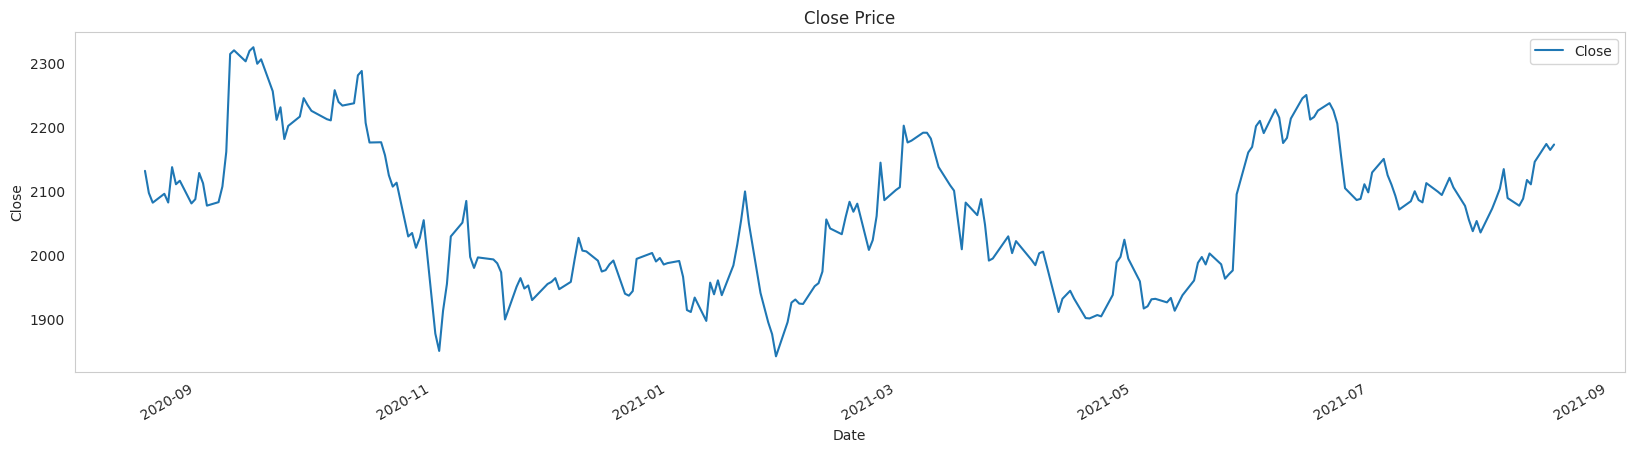

In [359]:
df_arima.plot(figsize=(20,5))
plt.ylabel('Close')
plt.title('Close Price')
plt.show()

### 3.2.2 Checking for stationarity using Augmented Dickey Fuller Test

In [360]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(trends):
    result = adfuller(trends)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')
        
adfuller_test(df_arima['Close'])

ADF Test Statistic: -2.798162044514932
p-value: 0.05853678692304586
#Lags Used: 1
#Observation Used: 247
week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


### 3.2.3 Differencing Data ==> Make it stationary

ADF Test Statistic: -14.085941856629944
p-value: 2.77541764417042e-26
#Lags Used: 0
#Observation Used: 247
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


<Axes: xlabel='Date'>

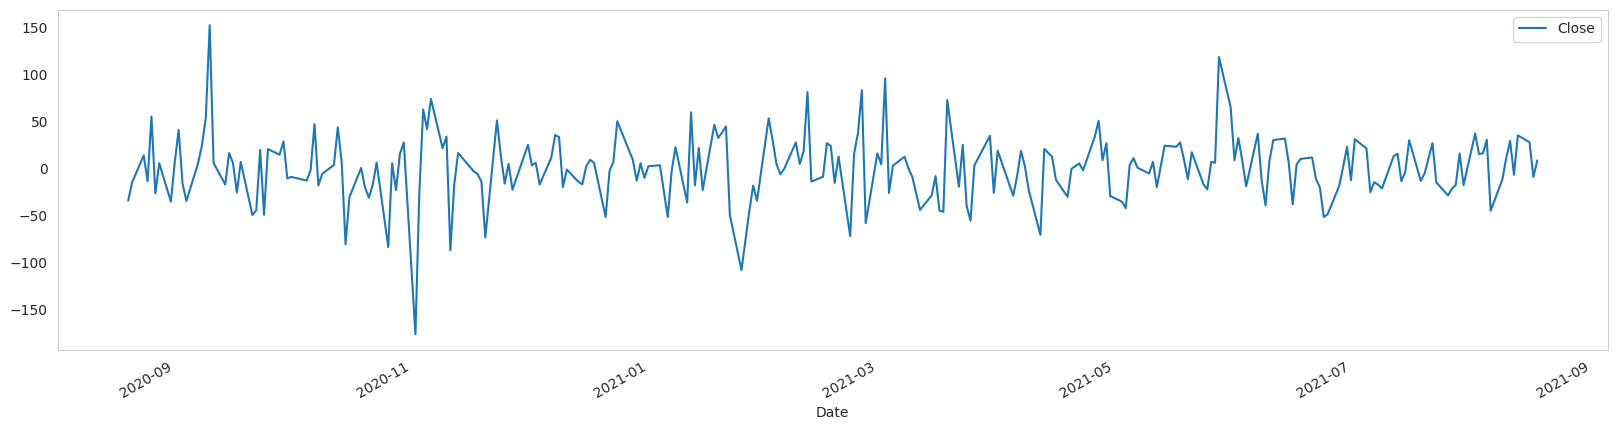

In [361]:
diff1=df_arima-df_arima.shift(1)
diff1=diff1.dropna()
adfuller_test(diff1)
diff1.plot(figsize=(20,5))

The data is now stationary and the order of differencing is 1.

### 3.2.4 Plotting Autocorrelation and Partial Autocorreltion functions

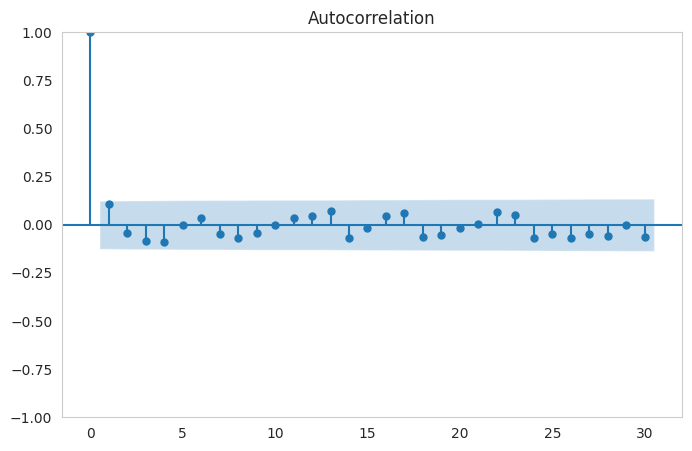

In [362]:
fig, ax = plt.subplots(figsize=(8, 5))
sgt.plot_acf(diff1['Close'], ax=ax, lags=30)
plt.show()

### 3.2.5 Model Implementation

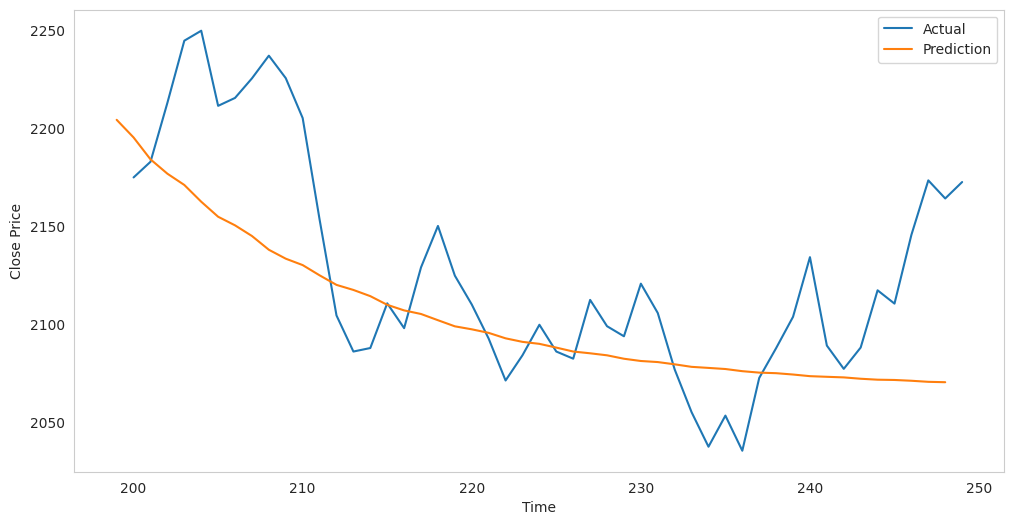

In [363]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Use the 'Close' column as the target variable
price = df['Close']
# price=price-price.shift(1)
# price=price.dropna()

# Split the data into training and testing sets
train_size = int(len(price) * 0.8)
train, test = price[:train_size], price[train_size:]

# Fit the ARIMA model
p, d, q = 3,1,5
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
predictions

# Plot the actual and predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(test.index, test)
plt.plot(predictions)
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend(['Actual', 'Prediction'])

In [364]:
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test, predictions)))
print("Test data MSE: ", mean_squared_error(test, predictions))
print("Test data MAE: ", mean_absolute_error(test, predictions))

-------------------------------------------------------------------------------------
Test data RMSE:  45.71734735207134
Test data MSE:  2090.075848909945
Test data MAE:  35.58409648145498


In [365]:
print("Test data explained variance regression score:", explained_variance_score(test, predictions))

Test data explained variance regression score: 0.5067193544255468


In [366]:
print("Test data R2 score:", r2_score(test, predictions))

Test data R2 score: 0.34956453827260137


In [367]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_y_train,y_train_pred_rf_ts)))

Train data RMSE:  15.192195385957103
